# Modelling via logistic regression

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pystan as stan
import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from scipy.stats import bernoulli
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import scipy
import itertools
import arviz as az
import sqlite3
from tqdm import tqdm

import seaborn as sns

sns.set()

pd.options.display.max_columns=None
pd.options.display.max_rows=100

SEED = 42
start_date = '2010-08-01'

/Users/saitosean/venvs/venv_soccer/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Load interim data

In [2]:
df_match_spain = pd.read_parquet('df_match_spain_sub.parquet').dropna()
df_match_spain_raw = pd.read_parquet('df_match_spain_raw.parquet')
print(df_match_spain.shape)
df_match_spain.head()

(1898, 98)


,id,country_id,league_id,season,stage,date,home_team_goal,away_team_goal,match_api_id,home_team_api_id,away_team_api_id,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA,year,home_result,target,home_overall_rating_1,home_potential_1,home_overall_rating_2,home_potential_2,home_overall_rating_3,home_potential_3,home_overall_rating_4,home_potential_4,home_overall_rating_5,home_potential_5,home_overall_rating_6,home_potential_6,home_overall_rating_7,home_potential_7,home_overall_rating_8,home_potential_8,home_overall_rating_9,home_potential_9,home_overall_rating_10,home_potential_10,home_overall_rating_11,home_potential_11,away_overall_rating_1,away_potential_1,away_overall_rating_2,away_potential_2,away_overall_rating_3,away_potential_3,away_overall_rating_4,away_potential_4,away_overall_rating_5,away_potential_5,away_overall_rating_6,away_potential_6,away_overall_rating_7,away_potential_7,away_overall_rating_8,away_potential_8,away_overall_rating_9,away_potential_9,away_overall_rating_10,away_potential_10,away_overall_rating_11,away_potential_11
0,22278,21518,21518,2010/2011,1,2010-08-30 00:00:00,4,0,875448,9906,9869,182917.0,30689.0,56678.0,32656.0,33636.0,38821.0,37411.0,25924.0,33871.0,38460.0,37412.0,75195.0,150480.0,107929.0,101070.0,74752.0,38746.0,30273.0,38004.0,38886.0,24383.0,41294.0,1.53,4.0,6.0,1.53,3.80,6.00,1.5,3.8,5.70,1.5,3.5,6.00,1.50,3.80,6.00,1.53,3.80,6.0,2010,1.0,win,78.0,85.0,79.0,84.0,81.0,82.0,76.0,81.0,77.0,84.0,82.0,85.0,80.0,83.0,78.0,80.0,75.0,81.0,87.0,88.0,84.0,90.0,77.0,78.0,72.0,73.0,77.0,78.0,78.0,79.0,74.0,79.0,74.0,79.0,75.0,76.0,74.0,77.0,76.0,77.0,78.0,79.0,74.0,79.0
1,22280,21518,21518,2010/2011,1,2010-08-29 00:00:00,0,3,875458,8696,8634,37579.0,75606.0,128037.0,37879.0,74435.0,26535.0,37512.0,46836.0,97319.0,38382.0,35638.0,32657.0,33988.0,37482.0,30738.0,34304.0,39854.0,154257.0,26146.0,30981.0,30909.0,30955.0,15.00,6.0,1.2,12.50,6.00,1.20,9.0,5.0,1.27,10.0,5.0,1.22,11.00,5.50,1.22,15.00,6.50,1.2,2010,-1.0,loss,74.0,80.0,74.0,75.0,77.0,82.0,73.0,80.0,74.0,75.0,70.0,76.0,75.0,80.0,70.0,74.0,73.0,76.0,75.0,79.0,77.0,86.0,85.0,86.0,84.0,90.0,85.0,88.0,82.0,85.0,79.0,84.0,87.0,90.0,81.0,84.0,81.0,85.0,90.0,95.0,88.0,92.0,87.0,90.0
2,22281,21518,21518,2010/2011,1,2010-08-28 00:00:00,1,3,875459,9864,10267,33826.0,33843.0,188517.0,41707.0,163236.0,11758.0,24612.0,128870.0,23779.0,56819.0,51545.0,24494.0,34007.0,30276.0,30914.0,26403.0,108568.0,30666.0,37824.0,41468.0,32762.0,33028.0,2.88,3.3,2.4,2.85,3.30,2.35,2.7,3.2,2.40,2.8,3.2,2.20,2.90,3.25,2.25,2.88,3.20,2.4,2010,-1.0,loss,67.0,72.0,78.0,82.0,72.0,73.0,76.0,77.0,67.0,75.0,74.0,77.0,73.0,77.0,74.0,76.0,72.0,85.0,73.0,81.0,69.0,74.0,79.0,80.0,77.0,81.0,79.0,81.0,77.0,81.0,77.0,85.0,81.0,86.0,78.0,81.0,80.0,87.0,82.0,88.0,79.0,74.0,79.0,81.0
3,22282,21518,21518,2010/2011,1,2010-08-29 00:00:00,0,0,875462,9783,8394,96651.0,33756.0,37451.0,70891.0,18853.0,37449.0,37793.0,114680.0,45744.0,31045.0,166111.0,30664.0,37754.0,33582.0,27668.0,150968.0,33635.0,30534.0,38403.0,164676.0,45457.0,8780.0,2.10,3.3,3.5,2.05,3.25,3.50,2.0,3.2,3.40,2.0,3.2,3.20,1.91,3.30,3.75,2.05,3.25,3.5,2010,0.0,draw,69.0,78.0,76.0,85.0,80.0,84.0,77.0,81.0,71.0,75.0,76.0,83.0,73.0,70.0,73.0,81.0,74.0,82.0,81.0,89.0,72.0,81.0,78.0,83.0,71.0,67.0,74.0,88.0,76.0,77.0,72.0,79.0,73.0,82.0,75.0,81.0,72.0,67.0,75.0,83.0,73.0,81.0,73.0,72.0
4,22284,21518,21518,2010/2011,1,2010-08-29 00:00:00,3,1,875464,8558,8305,113695.0,45440.0,183331.0,182921.0,33767.0,80492.0,121716.0,24852.0,37441.0,150330.0,40165.0,30992.0,41470.0,32675.0,75397.0,37622.0,34381.0,38431.0,75619.0,75307.0,37461.0,150770.0,2.10,3.3,3.5,2.15,3.25,3.25,2.0,3.2,3.40,2.1,3.2,3.00,2.10,3.

In [5]:
# Add target columns to raw data too

df_match_spain_raw['home_result'] = (df_match_spain_raw['home_team_goal'] - df_match_spain_raw['away_team_goal'])
df_match_spain_raw['home_result'] = df_match_spain_raw['home_result'].apply(lambda x: x/abs(x) if x != 0 else 0)
df_match_spain_raw['target'] = df_match_spain_raw['home_result'].map({0: 'draw', -1: 'loss', 1: 'win'})

In [6]:
print(sorted(df_match_spain['stage'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]


In [7]:
print(sorted(df_match_spain['season'].unique()))

['2010/2011', '2011/2012', '2012/2013', '2013/2014', '2014/2015', '2015/2016']


# Feature functions

In [8]:
def get_prev_year_result(row):
    """
    Binary flag of whether the home team won the same fixture the previous year
    """
    home_team_id = row['home_team_api_id']
    away_team_api_id = row['away_team_api_id']
    season = row['season']
    prev_season = '/'.join(map(lambda x: str(int(x) - 1), season.split('/')))
    df_prev = df_match_spain[
        (df_match_spain['home_team_api_id'] == home_team_id) &
        (df_match_spain['away_team_api_id'] == away_team_api_id) &
        (df_match_spain['season'] == prev_season)
    ]
    
    if df_prev.empty:
        return 0
    else:
        return 1 if df_prev['target'].values[0] == 'win' else 0
    
def get_recent_form(row):
    """
    Number of wins by the home team in the past 5 games
    """
    home_team_id = row['home_team_api_id']
    season = row['season']
    stage = row['stage']
    df_prev_matches = df_match_spain_raw[
        (df_match_spain_raw['season'] == season) & 
        ((df_match_spain_raw['home_team_api_id'] == home_team_id) |
         (df_match_spain_raw['away_team_api_id'] == home_team_id)) &
        (df_match_spain_raw['stage'].between(max(0, stage-5), max(0,stage-1)))
    ]
    
    if df_prev_matches.empty:
        return 0
    else:
        return sum(df_prev_matches['home_result'] == 'win')

In [9]:
df_match_spain['prev_year_result'] = df_match_spain.apply(get_prev_year_result, axis=1)

In [10]:
df_match_spain['wins_past_five_games'] = df_match_spain.apply(get_recent_form, axis=1)

In [11]:
df_match_spain["home_result"] = df_match_spain["home_result"].apply(lambda x: 1 if x > 0 else 0)
df_match_spain["home_result"].value_counts()

0    972
1    926
Name: home_result, dtype: int64

In [12]:
list_features = [
    'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA',
    'wins_past_five_games', 'prev_year_result', 'home_result',
]

target_col = "home_result"

In [13]:
df_features = df_match_spain[list_features]

X = df_features.drop(columns='home_result').values
y = df_features[target_col].values

print(X.shape)
print(y.shape)

(1898, 20)
(1898,)


In [14]:
np.unique(y)

array([0, 1])

## Scaling

In [15]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train_raw)
X_test = sc.transform(X_test_raw)

In [16]:
stan_model = '''

data {
    int<lower=0> N;
    int<lower=0> K;
    matrix[N, K] Q;
    int y[N];
}

parameters {
    real alpha; // intercept
    vector [K] theta; // coefficients on Q_ast
}

model {
    y ~ bernoulli_logit(Q * theta + alpha);  // likelihood
}

'''

In [17]:
data = dict(
    N=X_train.shape[0],
    K=X_train.shape[1],
    Q=X_train,
    y=y_train
)

In [18]:
model = stan.StanModel(model_code=stan_model, model_name="football_binary")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL football_binary_0d1cbc7e8af49b439e702ffb33882c05 NOW.


In [19]:
fit = model.sampling(data=data, chains=5, iter=2000, warmup=1000, control=dict(max_treedepth=15))

In [20]:
print(fit)

Inference for Stan model: football_binary_0d1cbc7e8af49b439e702ffb33882c05.
5 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=5000.

            mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
alpha      -0.41  3.4e-3   0.23   -0.85   -0.57  -0.42  -0.26   0.04   4482    1.0
theta[1]    2.21    0.12   8.18  -13.91   -3.33   2.28   7.73   18.3   4670    1.0
theta[2]   -0.65    0.08   5.82   -11.7   -4.56  -0.73   3.11  11.23   5026    1.0
theta[3]    0.35    0.08   5.31   -9.87   -3.28   0.24   4.02  10.71   4540    1.0
theta[4]   -8.98    0.13   9.49  -27.12   -15.6  -8.95  -2.71  10.05   4982    1.0
theta[5]     3.6    0.09    6.4    -9.3   -0.71   3.62    7.9  16.19   5449    1.0
theta[6]    0.06    0.07   5.14   -9.64   -3.53  -0.03   3.61  10.27   5097    1.0
theta[7]    1.35    0.07    4.7   -8.04   -1.69   1.44   4.51  10.49   4941    1.0
theta[8]    3.25    0.05    3.2   -2.98    1.09   3.15   5.

<AxesSubplot:>

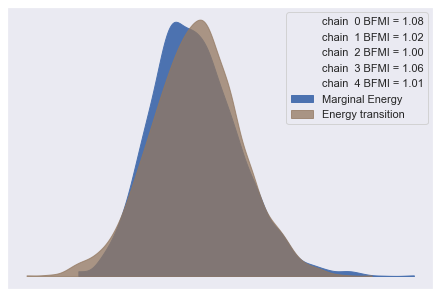

In [21]:
inf_data = az.convert_to_inference_data(fit)
az.plot_energy(inf_data)

In [22]:
list_features

['B365H',
 'B365D',
 'B365A',
 'BWH',
 'BWD',
 'BWA',
 'IWH',
 'IWD',
 'IWA',
 'LBH',
 'LBD',
 'LBA',
 'WHH',
 'WHD',
 'WHA',
 'VCH',
 'VCD',
 'VCA',
 'wins_past_five_games',
 'prev_year_result',
 'home_result']

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'theta\n0'}>,
        <AxesSubplot:title={'center':'theta\n1'}>],
       [<AxesSubplot:title={'center':'theta\n2'}>,
        <AxesSubplot:title={'center':'theta\n3'}>,
        <AxesSubplot:title={'center':'theta\n4'}>],
       [<AxesSubplot:title={'center':'theta\n5'}>,
        <AxesSubplot:title={'center':'theta\n6'}>,
        <AxesSubplot:title={'center':'theta\n7'}>],
       [<AxesSubplot:title={'center':'theta\n8'}>,
        <AxesSubplot:title={'center':'theta\n9'}>,
        <AxesSubplot:title={'center':'theta\n10'}>],
       [<AxesSubplot:title={'center':'theta\n11'}>,
        <AxesSubplot:title={'center':'theta\n12'}>,
        <AxesSubplot:title={'center':'theta\n13'}>],
       [<AxesSubplot:title={'center':'theta\n14'}>,
        <AxesSubplot:title={'center':'theta\n15'}>,
        <AxesSubplot:title={'center':'theta\n16'}>],
       [<AxesSubplot:title={'center':'theta\n17'}>,
        <AxesSubplot

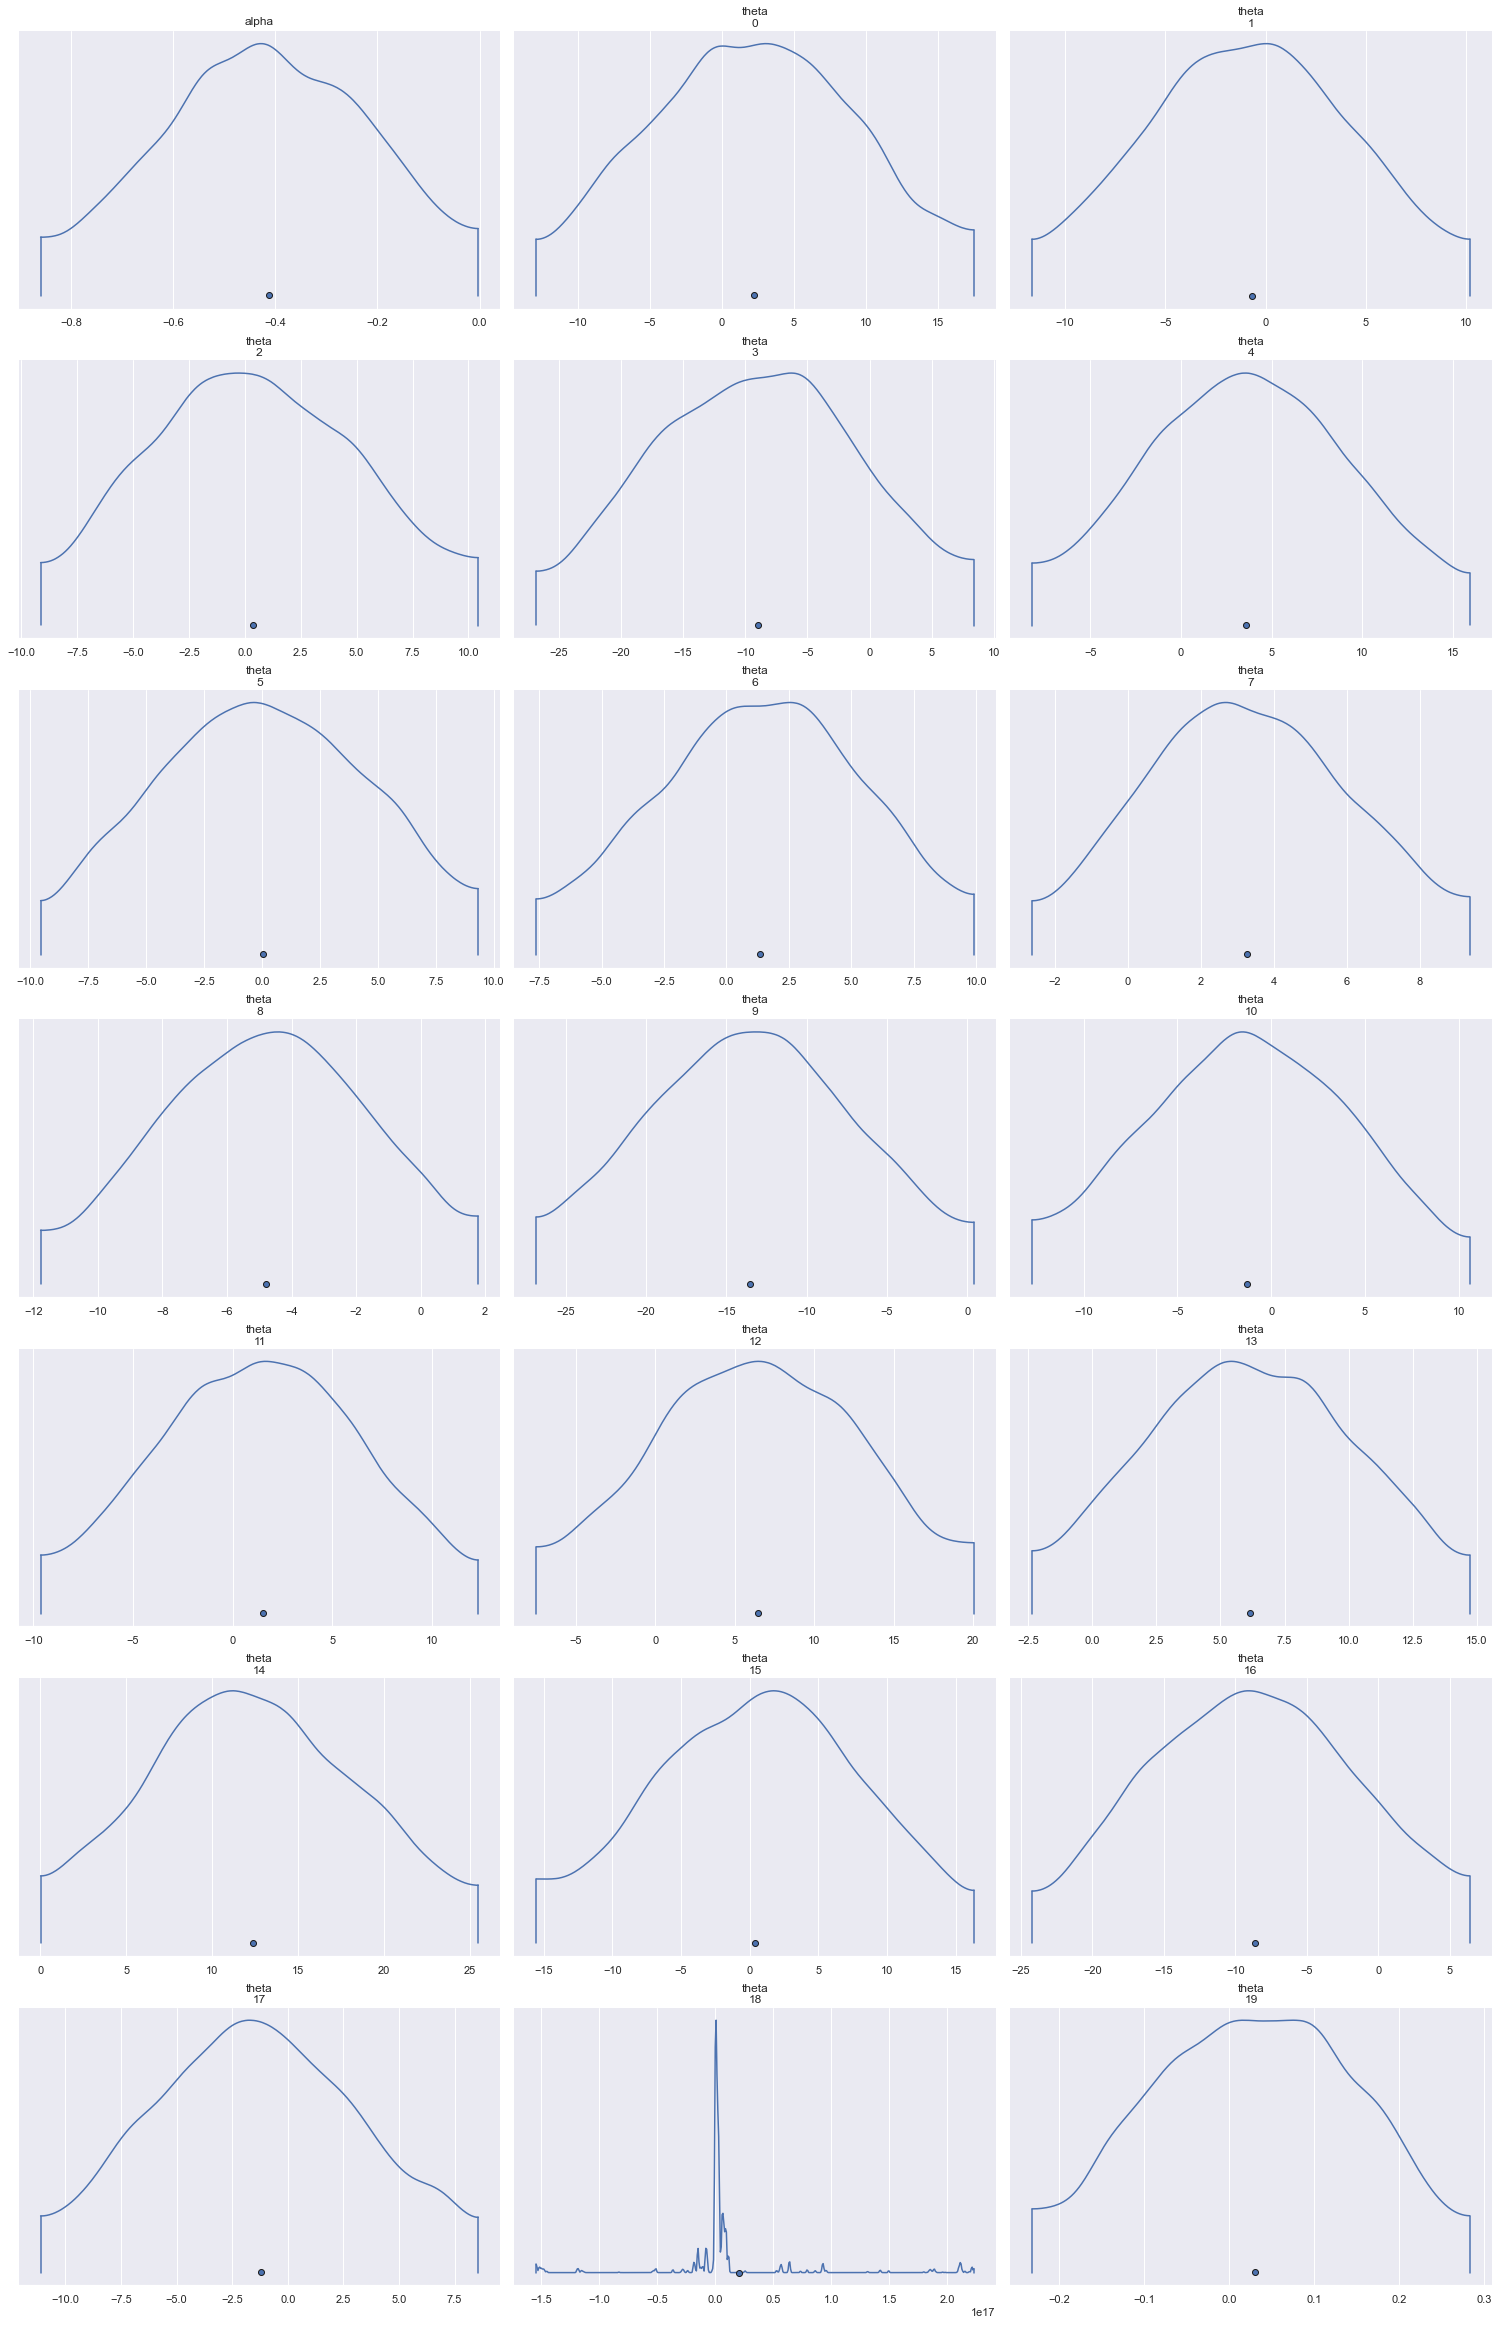

In [23]:
az.plot_density(inf_data)

# Get Test predictions

In [24]:
samples = fit.extract()
samples

OrderedDict([('alpha',
              array([-0.09595061, -0.66107419, -0.39581634, ..., -0.30259343,
                     -0.64430618, -0.48683437])),
             ('theta',
              array([[-1.59330398e+01,  2.61411417e+00,  6.20320403e+00, ...,
                      -1.97299748e+00,  9.28529086e+16, -7.01350399e-02],
                     [-5.10893648e+00, -4.52795972e+00,  3.31937613e+00, ...,
                      -2.12151863e+00,  6.32571609e+16,  2.09844127e-01],
                     [-6.42207486e+00,  2.32105228e+00,  1.50322523e+00, ...,
                       4.91812147e+00, -2.05006418e+17, -9.00941807e-02],
                     ...,
                     [ 2.35912295e+00,  9.88183589e+00,  8.68191706e+00, ...,
                      -2.45418657e+00,  1.94657974e+14, -1.48101777e-01],
                     [ 1.07299986e+01, -1.47883145e+01, -8.33888717e+00, ...,
                      -2.07664433e+00, -6.58229024e+14, -1.86073456e-01],
                     [ 2.57655352e+01,  

In [25]:
samples["theta"].shape

(5000, 20)

In [26]:
samples["alpha"].shape

(5000,)

In [27]:
outcomes = np.dot(samples["theta"], np.transpose(X_test))
print(outcomes.shape)

for j in range(outcomes.shape[1]):
    outcomes[:, j] = scipy.special.expit(outcomes[:, j] + samples["alpha"])
    outcomes[:, j] = bernoulli.rvs(p=outcomes[:, j], size=5000, random_state=42)
    
outcomes = np.transpose(outcomes)
print(outcomes.shape)
outcomes

(5000, 380)
(380, 5000)


array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 1.],
       [0., 1., 1., ..., 0., 1., 1.]])

In [28]:
predictions = outcomes.sum(axis=1)
y_pred = np.floor(predictions / 2501.)
print(y_pred.shape)
y_pred

(380,)


array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0.

In [29]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.78      0.70       191
           1       0.72      0.56      0.63       189

    accuracy                           0.67       380
   macro avg       0.68      0.67      0.67       380
weighted avg       0.68      0.67      0.67       380



In [30]:
print(metrics.accuracy_score(y_test, y_pred))

0.6710526315789473


# What if we take the most confident predictions?

In [31]:
outcomes_top = np.dot(samples["theta"], np.transpose(X_test))
print(outcomes_top.shape)

for j in range(outcomes_top.shape[1]):
    outcomes_top[:, j] = scipy.special.expit(outcomes_top[:, j] + samples["alpha"])
    
outcomes_top = np.transpose(outcomes_top)
print(outcomes_top.shape)
outcomes_top

(5000, 380)
(380, 5000)


array([[0.34928289, 0.42610334, 0.44969527, ..., 0.16454452, 0.56461333,
        0.13280774],
       [0.41717698, 0.39938156, 0.40337485, ..., 0.44468752, 0.36779745,
        0.39621874],
       [0.46406996, 0.47529296, 0.46599749, ..., 0.41780338, 0.5133463 ,
        0.50345121],
       ...,
       [0.39917569, 0.35294495, 0.38902041, ..., 0.40333407, 0.40665958,
        0.36796384],
       [0.45475023, 0.44644892, 0.48076967, ..., 0.47815315, 0.42327801,
        0.40904877],
       [0.38895474, 0.41100257, 0.4023734 , ..., 0.39979265, 0.38270973,
        0.41381493]])

In [51]:
list_top_idxes = np.argsort(outcomes_top.mean(axis=1))[::-1]
start = 4
list_top_idxes = list_top_idxes[start*len(list_top_idxes)//5:(start+1)*len(list_top_idxes)//5]
list_top_idxes

array([369, 254, 144, 323, 310, 258, 240,  22, 225, 165, 207, 251, 126,
       124, 248, 301, 145,  87, 306, 227, 113, 347,  53, 233, 253, 311,
         0, 105,  91, 285, 327, 136, 371, 277, 150, 166,  72, 374, 343,
       102, 274, 249, 364, 197, 242, 302, 279,  31, 216, 322,  18, 122,
       211,   3, 142, 244, 305,  96, 345,  33,  76, 127,  23, 289, 260,
       114, 229,  69, 186,  71,  54, 287, 261, 196,  21, 296])

In [52]:
y_pred_new = np.take(y_pred, list_top_idxes)
y_test_new = np.take(y_test, list_top_idxes)

In [53]:
print(metrics.classification_report(y_test_new, y_pred_new))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86        57
           1       0.00      0.00      0.00        19

    accuracy                           0.75        76
   macro avg       0.38      0.50      0.43        76
weighted avg       0.56      0.75      0.64        76



/Users/saitosean/venvs/venv_soccer/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saitosean/venvs/venv_soccer/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saitosean/venvs/venv_soccer/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [54]:
print(metrics.accuracy_score(y_test_new, y_pred_new))

0.75


In [55]:
y_pred_new

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [57]:
list_buf = []
n=10
for i in range(n):
    list_top_idxes = np.argsort(outcomes_top.mean(axis=1))[::-1]
    list_top_idxes = list_top_idxes[i*len(list_top_idxes)//n:(i+1)*len(list_top_idxes)//n]
    y_pred_new = np.take(y_pred, list_top_idxes)
    y_test_new = np.take(y_test, list_top_idxes)
    a = metrics.accuracy_score(y_test_new, y_pred_new)
    list_buf.append(a)
    
list_buf

[0.8947368421052632,
 0.631578947368421,
 0.6842105263157895,
 0.6842105263157895,
 0.47368421052631576,
 0.5263157894736842,
 0.6052631578947368,
 0.7105263157894737,
 0.6842105263157895,
 0.8157894736842105]

# Visualizations

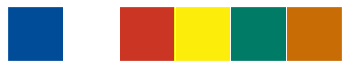

In [35]:
team_colors = [
    "#004C99",
    "#FFFFFF",
    "#CB3524",
    "#FCED0B",
    "#007c66",
    "#c86c05",
]

sns.set_palette(team_colors)
sns.palplot(sns.color_palette())

In [36]:
# sns.color_palette("hls", 8)

In [37]:
df_team_spain = pd.read_parquet("df_team_spain.parquet")
df_team_spain

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
251,43035,10267,461.0,Valencia CF,VAL
252,43036,8661,453.0,RCD Mallorca,MAL
253,43037,8371,479.0,CA Osasuna,OSA
254,43038,10205,483.0,Villarreal CF,VIL
255,43039,9783,242.0,RC Deportivo de La Coruña,COR
256,43040,8633,243.0,Real Madrid CF,REA
258,43042,8634,241.0,FC Barcelona,BAR
259,43043,8696,456.0,Racing Santander,SAN
260,43044,8302,481.0,Sevilla FC,SEV
261,43045,9869,459.0,Real Sporting de Gijón,SPG


In [38]:
df_match_spain["home_team_api_id"].value_counts().reset_index()

,index,home_team_api_id
0,9906,108
1,8302,106
2,8560,104
3,10267,103
4,8633,101
5,8634,100
6,8305,94
7,8558,92
8,9864,91
9,8581,90


In [39]:
pd.merge(
    df_team_spain[["team_api_id", "team_long_name", "team_short_name"]],
    df_match_spain["home_team_api_id"].value_counts().reset_index(),
    left_on="team_api_id",
    right_on="index",
    how="left"
)

,team_api_id,team_long_name,team_short_name,index,home_team_api_id
0,10267,Valencia CF,VAL,10267,103
1,8661,RCD Mallorca,MAL,8661,39
2,8371,CA Osasuna,OSA,8371,57
3,10205,Villarreal CF,VIL,10205,85
4,9783,RC Deportivo de La Coruña,COR,9783,65
5,8633,Real Madrid CF,REA,8633,101
6,8634,FC Barcelona,BAR,8634,100
7,8696,Racing Santander,SAN,8696,30
8,8302,Sevilla FC,SEV,8302,106
9,9869,Real Sporting de Gijón,SPG,9869,33


In [40]:
list_teams = [
    "BAR",
    "REA",
    "AMA",
    "GET",
    "RAY",
    "ALM",
]

dict_team_to_id = df_team_spain.set_index("team_short_name")["team_api_id"].to_dict()
dict_team_to_long = df_team_spain.set_index("team_short_name")["team_long_name"].to_dict()
list_team_ids = [dict_team_to_id[t] for t in list_teams]
list_team_ids

[8634, 8633, 9906, 8305, 8370, 9865]

### Calculate posterior wins for each team and prepare for violin plot

In [41]:
def calculate_posteriors(X_features, theta, alpha):
    outcomes = np.dot(theta, np.transpose(X_features))
    print(outcomes.shape)

    for j in range(outcomes.shape[1]):
        outcomes[:, j] = scipy.special.expit(outcomes[:, j] + alpha)

    outcomes = np.transpose(outcomes)
    return outcomes

In [42]:
list_buf = []

theta = samples["theta"]
alpha = samples["alpha"]


for team in tqdm(list_teams):
    team_id = dict_team_to_id[team]

    df_matches_team = df_match_spain[df_match_spain["home_team_api_id"] == team_id].sample(10)
    df_features_team = df_matches_team[list_features]
    df_features_team = df_features_team.drop(columns=target_col)
    X_features = sc.transform(df_features_team.values)
    outcomes = calculate_posteriors(X_features, theta, alpha)

    df_post = pd.DataFrame({"posteriors": outcomes.ravel()})
    df_post["team"] = dict_team_to_long[team]
    list_buf.append(df_post)
    
df_posteriors = pd.concat(list_buf)
df_posteriors.head()

  0%|          | 0/6 [00:00<?, ?it/s]

(5000, 10)
(5000, 10)
(5000, 10)


100%|██████████| 6/6 [00:00<00:00, 172.12it/s]

(5000, 10)
(5000, 10)
(5000, 10)


,posteriors,team
0,0.875997,FC Barcelona
1,0.947648,FC Barcelona
2,0.848806,FC Barcelona
3,0.652794,FC Barcelona
4,0.687462,FC Barcelona


[Text(0, 0.5, ''),
 Text(0.5, 0, 'Posterior'),
 Text(0.5, 1.0, 'Home team win probability distribution')]

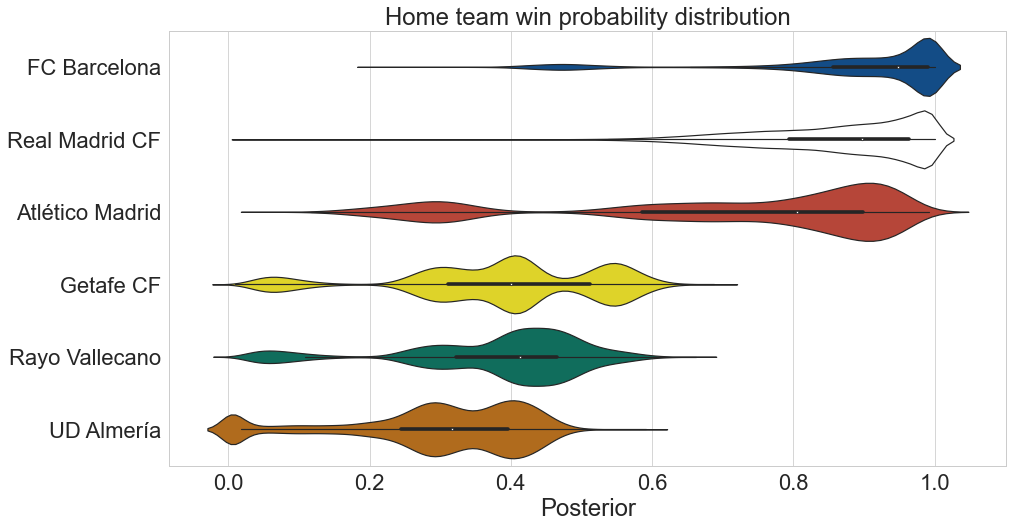

In [43]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))
sns.set_context('paper', font_scale=2.5)
sns.set_palette(team_colors)

ax = sns.violinplot(y="team", x="posteriors", data=df_posteriors, scale="width", orient="h")
ax.set(ylabel="", xlabel="Posterior", title="Home team win probability distribution")

# Barcelona vs the other teams

In [44]:
list_buf = []

theta = samples["theta"]
alpha = samples["alpha"]

barcelona = list_teams[0]
bar_id = dict_team_to_id[barcelona]

for away_team in tqdm(list_teams[1:]):
    team_id = dict_team_to_id[away_team]

    df_matches_team = df_match_spain[
        (df_match_spain["away_team_api_id"] == team_id) &
        (df_match_spain["home_team_api_id"] == bar_id)]
    
    df_features_team = df_matches_team[list_features]
    df_features_team = df_features_team.drop(columns=target_col)
    X_features = sc.transform(df_features_team.values)
    outcomes = calculate_posteriors(X_features, theta, alpha)

    df_post = pd.DataFrame({"posteriors": outcomes.ravel()})
    df_post["away_team"] = dict_team_to_long[away_team]
    list_buf.append(df_post)
    
df_posteriors = pd.concat(list_buf)
df_posteriors.head()

100%|██████████| 5/5 [00:00<00:00, 233.80it/s]

(5000, 6)
(5000, 6)
(5000, 3)
(5000, 4)
(5000, 3)


,posteriors,away_team
0,0.533736,Real Madrid CF
1,0.437169,Real Madrid CF
2,0.428995,Real Madrid CF
3,0.440023,Real Madrid CF
4,0.479585,Real Madrid CF


[Text(0, 0.5, ''),
 Text(0.5, 0, 'Posterior'),
 Text(0.5, 1.0, 'FC Barcelona win probability vs. peers')]

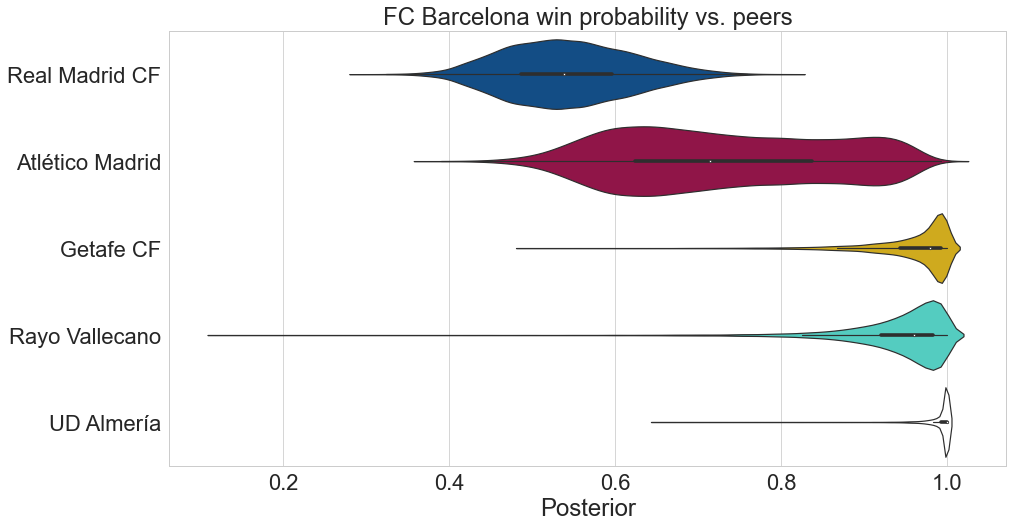

In [45]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))
sns.set_context('paper', font_scale=2.5)

barcelona_colors = [
    "#004D98",
    "#A50044",
    "#EDBB00",
    "#40E0D0",
    "#FFFFFF",
]

sns.set_palette(barcelona_colors)

ax = sns.violinplot(y="away_team", x="posteriors", data=df_posteriors, scale="width", orient="h")
ax.set(ylabel="", xlabel="Posterior", title="FC Barcelona win probability vs. peers")

## Plot the following

* Home win odds vs. probability
* Home draw odds vs. probability
* Away win odds vs. probability

In [46]:
list_features

['B365H',
 'B365D',
 'B365A',
 'BWH',
 'BWD',
 'BWA',
 'IWH',
 'IWD',
 'IWA',
 'LBH',
 'LBD',
 'LBA',
 'WHH',
 'WHD',
 'WHA',
 'VCH',
 'VCD',
 'VCA',
 'wins_past_five_games',
 'prev_year_result',
 'home_result']

In [47]:
outcomes = calculate_posteriors(X_test, theta, alpha)
outcomes.shape

(5000, 380)


(380, 5000)

In [48]:
outcomes.mean(axis=1).shape

(380,)

In [49]:
list_bet_features = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA']

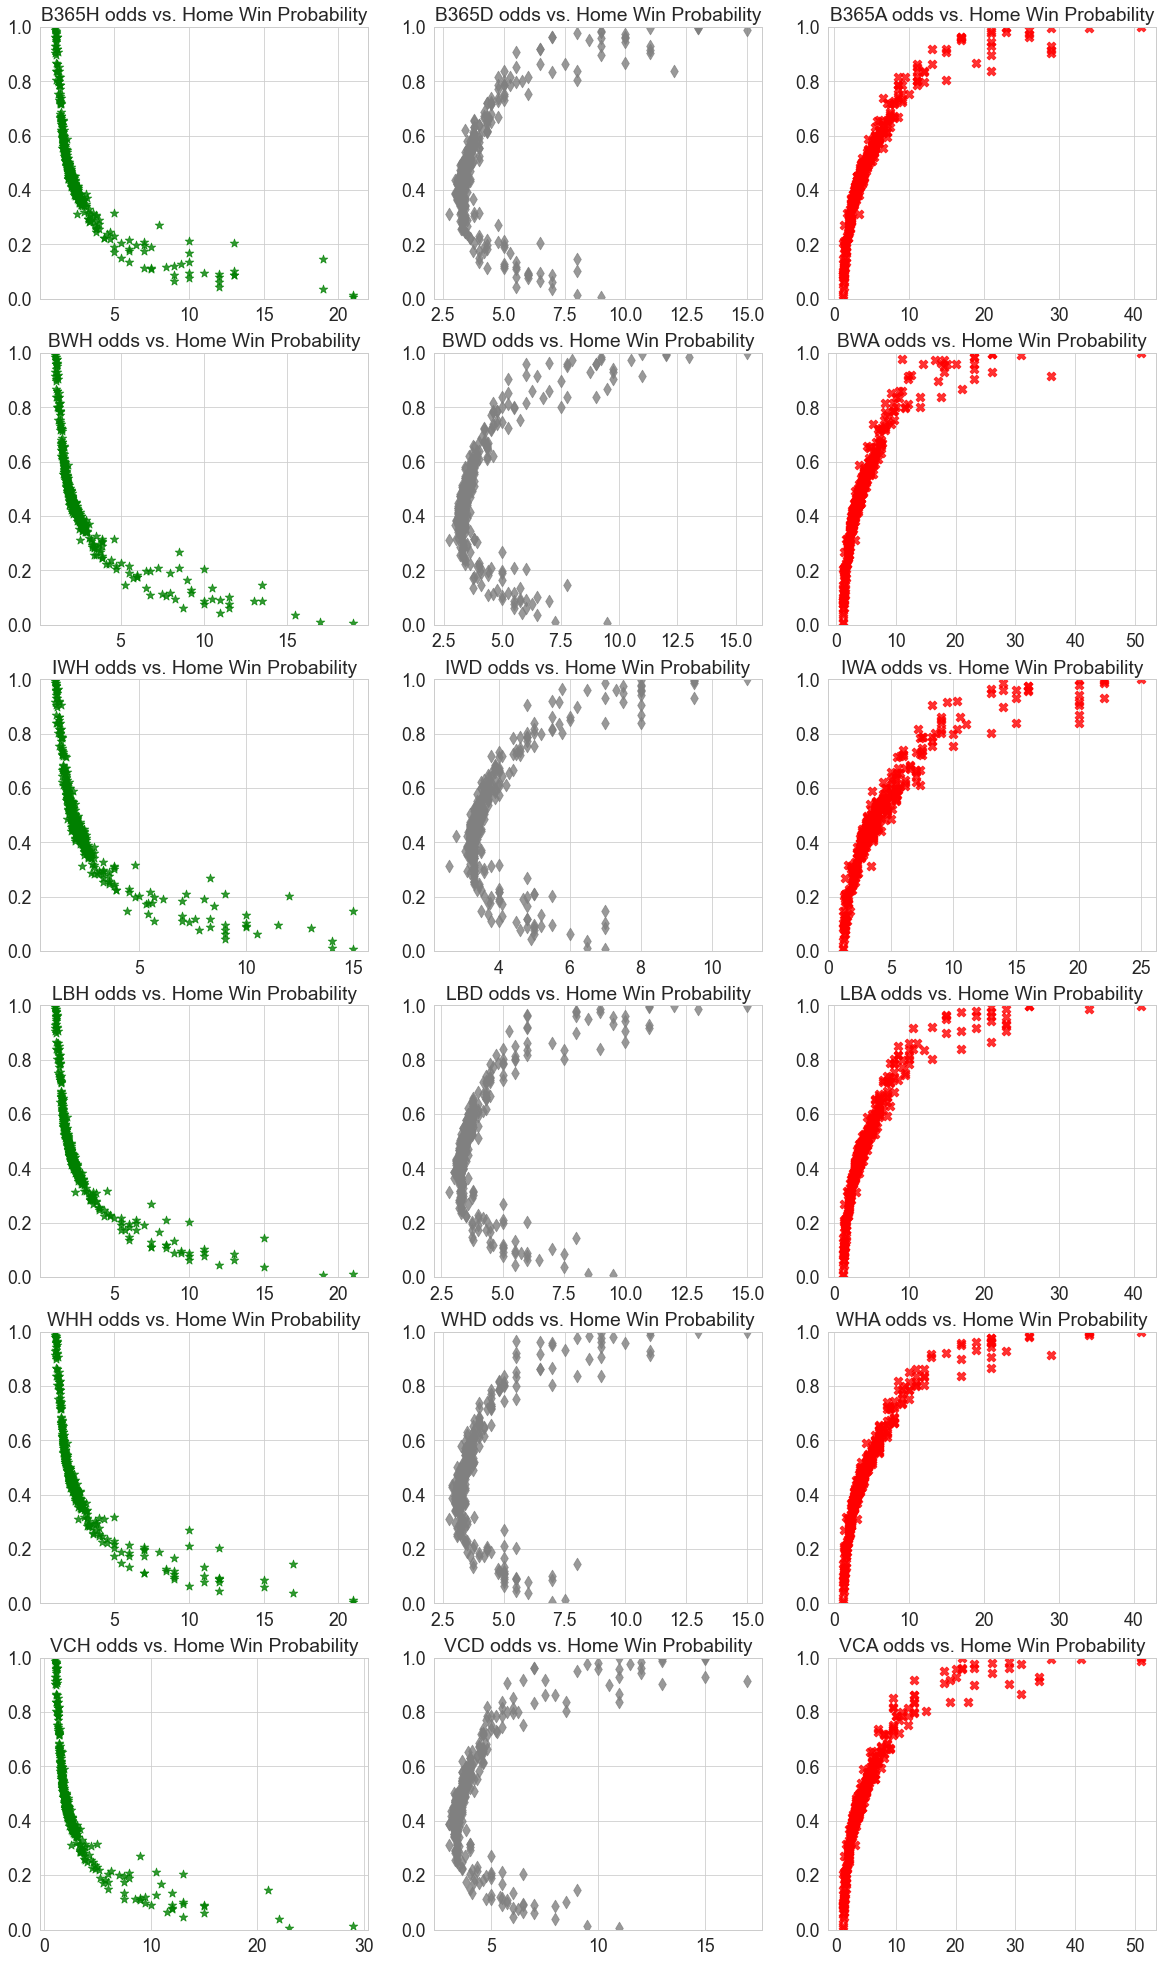

In [52]:
skip = 1
sns.set_context('paper', font_scale=2.0)
fig, axs = plt.subplots(len(list_bet_features) // 3, 3, figsize=(20, 35))
markers = ["*", "d", "X"]
colors = ["green", "grey", "red"]

for idx, feat in enumerate(list_bet_features):
    
    x = X_test_raw[:, idx]
    y = outcomes.mean(axis=1)
    
    unique, args = np.unique(np.argsort(x), return_index=True)
    x = np.take(x, args)
    y = np.take(y, args)

    args = np.argsort(x)
    x = np.take(x, args)[::skip]
    y = np.take(y, args)[::skip]

    
    intervals = []
    for row in outcomes:
        ci = 1.96 * np.std(row) / np.mean(row)
        intervals.append(ci)
        
    intervals = np.take(np.array(intervals), args)[::skip]
    
    ax = axs[idx//3][idx%3]
    
    ax.scatter(x, y, marker=markers[idx%3], c=colors[idx%3], s=80, alpha=0.8)
    ax.set_title("{} odds vs. Home Win Probability".format(feat))
    ax.set_ylim([0, 1])